In [166]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import IPython.display as display
from PIL import Image
import numpy as np
import pathlib
import tensorflow as tf
from keras.layers import Input, Dense, Flatten, Conv1D, Reshape, MaxPooling2D
from keras import Sequential, Model
from matplotlib import pyplot as plt

In [2]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [235]:
#path = input("Enter directory:")
path = '/Users/mengchen/Documents/Research Projects/Machine Learning/Simulated/'
data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('*/*.jpg')))

In [4]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != '.DS_Store'])

In [ ]:
Triticites = list(data_dir.glob('Triticites/*'))

for species in Triticites[:3]:
    display.display(Image.open(str(species)))

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEP_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [239]:
train_generator = image_generator.flow_from_directory(directory=str(data_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES))
                                                      #color_mode='grayscale')

Found 6928 images belonging to 6 classes.


In [240]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

In [241]:
image_batch, label_batch = next(train_generator)
#show_batch(image_batch, label_batch)
image_batch.shape

(32, 224, 224, 3)

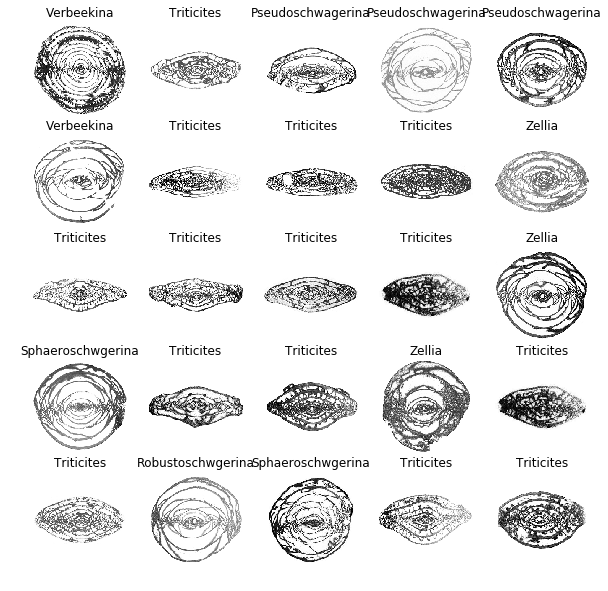

In [242]:
show_batch(image_batch, label_batch)

In [243]:
path = '/Users/mengchen/Documents/Research Projects/Machine Learning/JPG/'
data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('*/*.jpg')))

valid_generator = image_generator.flow_from_directory(directory=str(data_dir),
                                                      batch_size=1,
                                                      shuffle=True,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES))

Found 119 images belonging to 6 classes.


In [246]:
def build_cnn(input_size=(224, 224, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu')(inputs)
    conv1 = Conv2D(64, 3, activation='relu')(conv1)
    #pool1 = MaxPooling2D(pool_size=(3, 3))(conv1)
    dense1 = Dense(128, activation='relu')(conv1)
    dense2 = Dense(6, activation='softmax')(dense1)
    model = Model(inputs=inputs, outputs=dense2)
    model.compile(optimizer = 'Adam', 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model

In [247]:
model = build_cnn()
model.summary()

AttributeError: 'InputLayer' object has no attribute 'outbound_nodes'

In [221]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=valid_generator,
                    validation_steps=step_size_valid,
                    epochs=10,
                    verbose = 1)

Epoch 1/10


ValueError: Error when checking input: expected input_45 to have 3 dimensions, but got array with shape (32, 224, 224, 3)

In [114]:
image_batch, label_batch =  next(train_generator)
image_batch, label_batch

(array([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         ...,
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],
 
 
        [

In [68]:
data_dir

PosixPath('/Users/mengchen/Documents/Research Projects/Machine Learning/JPG')

In [ ]:
# tf 2.0
AUTOTUNE = tf.data.experimental.AUTOTUNE

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

def get_label(path):
    parts = tf.strings.split(path, '/')
    return parts[-2] == CLASS_NAMES

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(imag, tf.float32)
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(path):
    label = get_label(path)
    img = tf.io.read_file(path)
    img = decode_image(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls= AUTOTUNE)